# 3. Scatter graph와 Correlation
- github colab : https://homl.info/colab3

In [1]:
import matplotlib
import numpy
import pathlib
import pandas
import sklearn
import sklearn.model_selection
import tarfile
import urllib

def ch2_load_housing_data():
    tarball_path = pathlib.Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        pathlib.Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pandas.read_csv(pathlib.Path("datasets/housing/housing.csv"))

def matplotlib_to_imagefile(output_dir, filename, imgext="png", tight_layout=True, resolution=300):
    path = output_dir / f"{filename}.{imgext}"
    if tight_layout:
        matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.savefig(path, format=imgext, dpi=resolution)
    
def stratified_sampling_income_category(input_dataframe):
    input_dataframe = input_dataframe.copy()
    input_dataframe["income_cat"] = pandas.cut(input_dataframe["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., numpy.inf],
                               labels=[1, 2, 3, 4, 5])
    s_train, s_test = sklearn.model_selection.train_test_split(input_dataframe, test_size = 0.2, stratify = input_dataframe['income_cat'], random_state = 42)
    s_train.drop('income_cat', axis=1, inplace=True)
    s_test.drop('income_cat', axis=1, inplace=True)
    
    return s_train, s_test
    
# 저장할 디렉토리 설정
output_dir = pathlib.Path() / "images" / "end_to_end_project"
output_dir.mkdir(parents=True, exist_ok=True)
print(f'output_dir : {output_dir}')

input_dataframe = ch2_load_housing_data()
train, test = stratified_sampling_income_category(input_dataframe)

output_dir : images\end_to_end_project


C:\Users\ctint\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


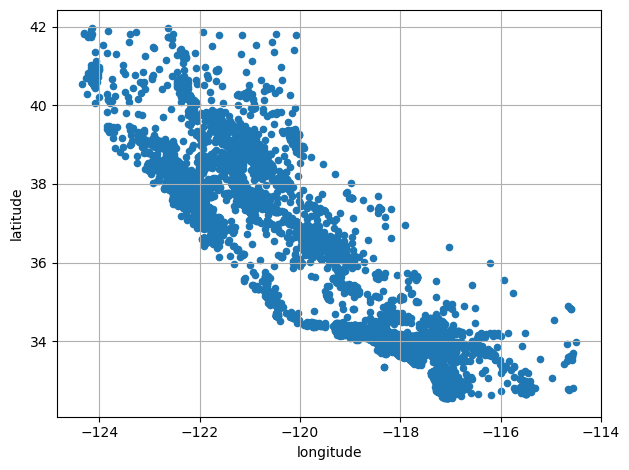

In [2]:
#
# Bad visualization의 예
# 대충 캘리포니아인건 알겠는데 어디가 집중된데고 어디가 아닌지 이걸로 파악하기 애매하다
#
train.plot(kind='scatter', x='longitude', y='latitude', grid = True)
matplotlib_to_imagefile(output_dir, 'bad_visulization_plot')
matplotlib.pyplot.show()

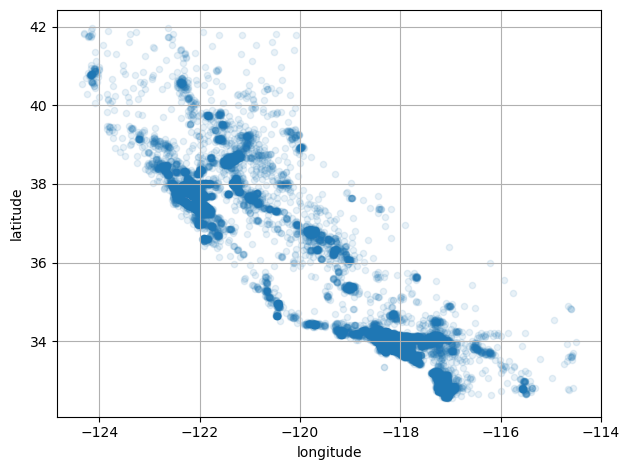

In [3]:
#
# 좀 나은 visualization
# Alpha값을 줘서 좀 더 구분이 용이해짐
# 
train.plot(kind='scatter', x='longitude', y='latitude', grid=True, alpha=0.1)
matplotlib_to_imagefile(output_dir, 'better_visualization_plot')
matplotlib.pyplot.show()

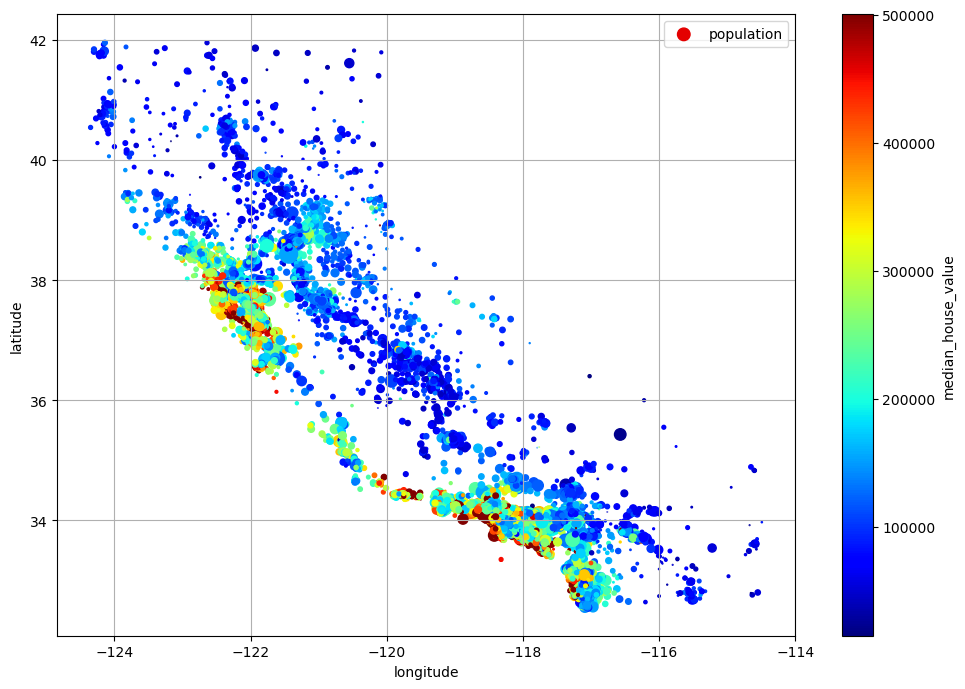

In [4]:
#
# 발전된 visualization
# s = radius of each point
# c = color of circle
# cmap = color style
#
train.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=train["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))

matplotlib_to_imagefile(output_dir, "housing_prices_scatterplot")

# Not necessary for jupyter. Necessary for normal python execution
matplotlib.pyplot.show()

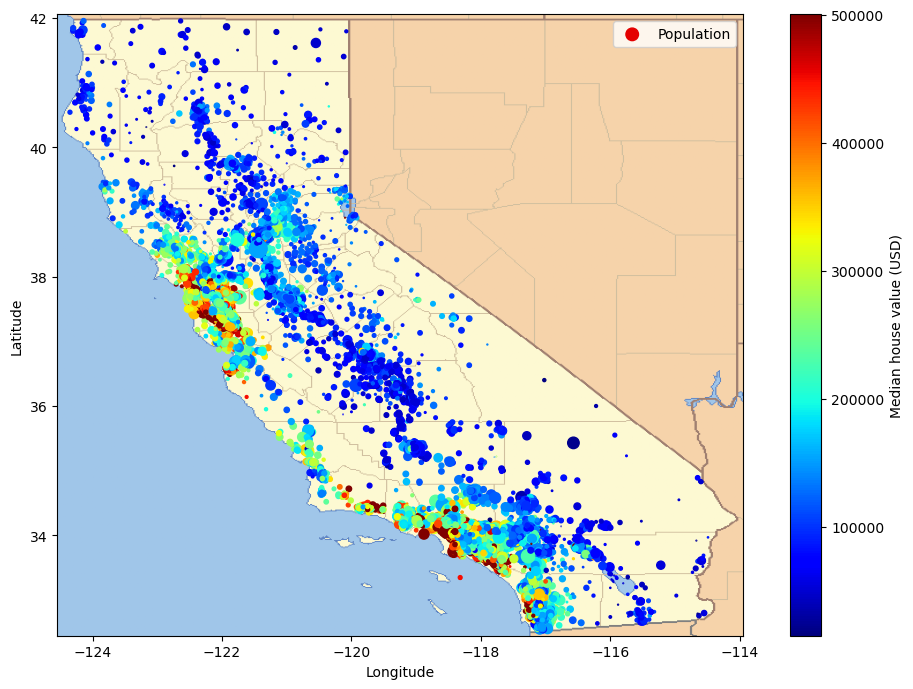

In [5]:
#
# California 지도까지 포함하는 visualization
# 근데 지도를 애초에 잘 잘라와야 이렇게 잘 나오는 듯...
#
# Download the California image
filename = "california.png"
if not (output_dir / filename).is_file():
    homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
    url = homl3_root + "images/end_to_end_project/" + filename
    print("Downloading", filename)
    urllib.request.urlretrieve(url, output_dir / filename)

#
# inplace = False가 default이므로 새로운 DataFrame instance가 리턴된다
#
train_ren = train.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (USD)"})

train_ren.plot(
             kind="scatter", x="Longitude", y="Latitude",
             s=train_ren["Population"] / 100, label="Population",
             c="Median house value (USD)", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))

california_img = matplotlib.pyplot.imread(output_dir / filename)

axis = -124.55, -113.95, 32.45, 42.05
matplotlib.pyplot.axis(axis)

#
# matplotlib은 imshow를 해야 image를 뿌려주는 듯? imread로는 읽기만 하는 모양
#
# matplotlib.pyplot.imshow(california_img, extent=(-123,-115,35,40)) # for showing effect of extent=axis
matplotlib.pyplot.imshow(california_img, extent=axis)
# matplotlib.pyplot.imshow(california_img)

matplotlib_to_imagefile(output_dir, "california_housing_prices_plot")
matplotlib.pyplot.show()

## Correlation과 Scatter graph
- correlation이 있는지 살펴보기에 scatter graph가 좋음
- correlation은 linear relationship만 설명하기 때문에 correlation이 없다고 상관이 없다거나 correlation이 좀 있으니까 상관이 좀 있다거나 하는 건 섣부른 생각임

In [6]:
#
# DataFrame안에 있는 data 간의 correlation은 corr을 이용해 간단하게 알아볼 수 있음
#
corr_matrix = train.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

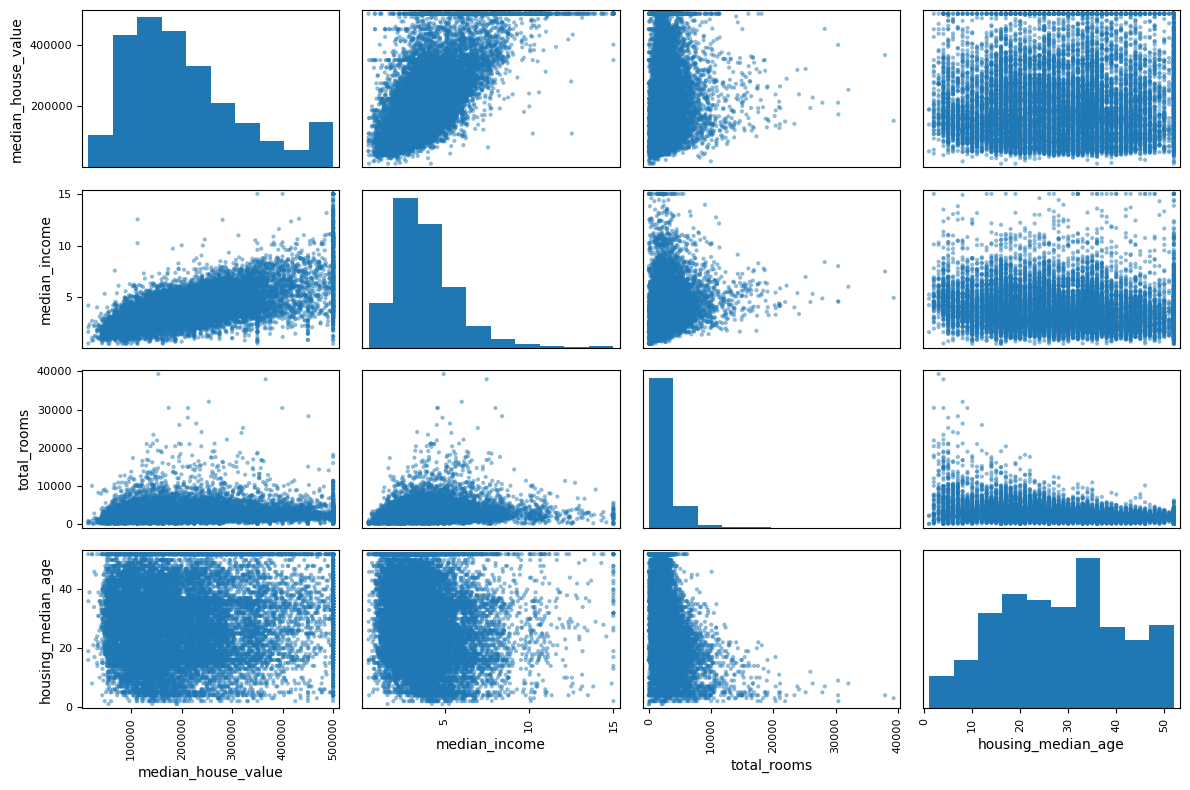

In [7]:
#
# pandas.plotting.scatter_matrix를 이용하면 Graph로도 쉽게 나타낼 수 있다
# 우하 대각선은 histogram으로 그려주고 나머지는 scatter graph로 보여 준다
# column이 N이면 correlation종류는 N^2개가 되니까 잘 선택해서 하는게 좋다
#  
attributes =  ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
# DataFrame [] operator에 index array를 넣어 필터링 하는것 참고 
pandas.plotting.scatter_matrix(train[attributes], figsize=(12,8))
matplotlib_to_imagefile(output_dir, "scatter_matrix_plot")
matplotlib.pyplot.show()

### Scatter graph를 한번 자세히 보는게 좋은 이유
- Data를 본인이 만든게 아니라면 Data가 내 생각대로 만들어졌을 거란 가정은 안하는게 좋다
- min/max cap이 존재한다거나, 터무니 없는 outlier가 존재한다거나, 뭔가 artifact까 존재한다거나 할 수 있다
- scatter graph는 이런걸 파악하기 좋다

C:\Users\ctint\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


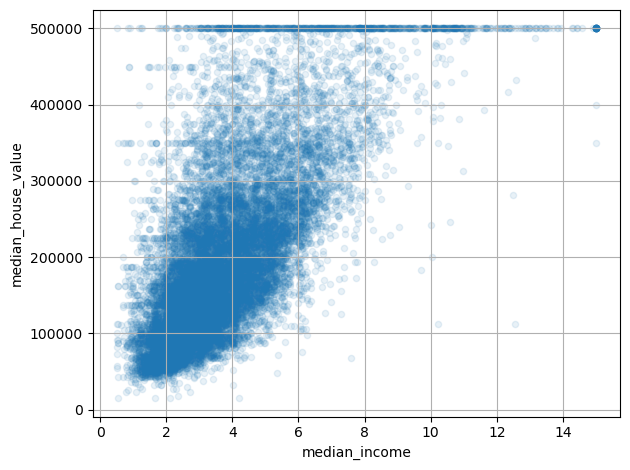

In [8]:
#
# 이걸 보면 500,000에 뭔가 max cap이 존재하며
# 그 외에도 350,000근처, 280,000 근처, 220,000 근처에 뭔가 직선이 있다는걸 알 수 있다
# 이 부분이 우연인지 아닌지에 대해 파악할 필요가 있을것이다 (그러나 여기서는 그렇게 자세히 안함)
#

train.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1, grid=True)
matplotlib_to_imagefile(output_dir, "income_vs_house_value_scatterplot")  # extra code
matplotlib.pyplot.show()

In [9]:
#
# Raw data에서 correlation이 안보인다면 다소 가공해 볼 수 있다
#
train["rooms_per_house"]  = train["total_rooms"]    / train["households"]
train["bedrooms_ratio"]   = train["total_bedrooms"] / train["total_rooms"]
train["people_per_house"] = train["population"]     / train["households"]

# rooms_per_house, bedrooms_ratio가 뭔가 correlation이 꽤 있다는걸 알 수 있음
corr_matrix = train.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64